# 📘 cuda_optics: Complete Documentation

Welcome to the official reference for **cuda_optics**. This notebook serves as both a manual and an interactive playground.
Kindly normalize your optical system before proceeding to avoid floating point precision errors.

All the examples in this document run on the CPU engine. To utilise the GPU, put a `True` for the argument `use_gpu`.

## 📑 Index
1.  [Core Functions (Simulation & Plotting)](#1.-Core-Functions)
2.  [Beam Generation](#2.-Beam-Generation)
3.  [Screens & Apertures](#3.-Screens-&-Apertures)
4.  [Thin Lenses & Gratings](#4.-Thin-Lenses-&-Gratings)
5.  [Mirrors (Flat, Spherical, Parabolic)](#5.-Mirrors)
6.  [Refractive Elements (Slab, Thick Lens, Prism)](#6.-Refractive-Elements)
7.  [Analysis Tools](#7.-Analysis)
8.  [Complex Examples](#8.-Complex-Examples)

---

In [2]:
import cuda_optics as co
import matplotlib.pyplot as plt
import numpy as np

print("cuda_optics loaded! Ready to simulate.")

cuda_optics loaded! Ready to simulate.


## 1. Core Functions
These are the two most important functions you will use in every simulation.

### `co.run_simulation(rays, elements, bounces, use_gpu)`
The engine that calculates ray physics.
* **`rays`** *(list)*: List of `Ray` objects to simulate.
* **`elements`** *(list)*: List of `OpticalElement` objects in the scene.
* **`bounces`** *(int)*: Max number of interactions allowed per ray. (e.g., 5-10 for simple systems, 50+ for traps).
* **`use_gpu`** *(bool)*: If `True`, attempts to use CUDA. If `False`, uses the CPU.

### `co.plot_system(rays, elements, ax)`
Visualizes the results on a Matplotlib axis.
* **`rays`** *(list)*: The rays (after simulation).
* **`elements`** *(list)*: The elements to draw.
* **`ax`** *(matplotlib.axes)*: The subplot to draw on.

## 2. Beam Generation
Instead of creating individual rays manually, use these helpers.

### A. `generate_parallel_beam`
Creates a collimated beam (infinite conjugate source).
* **`wavelengths`**: List of tuples `(nm, 'color')`. Note that only the value in nm is relevant and the colour argument is only used for plotting. 
* **`source_pos`**: `[x, y]` start point.
* **`target_element_centre`**: `[x, y]` point to aim at.
* **`target_element_aperture`**: Width of the beam is taken to be 90% of the target_element_aperture argument.
* **`num_rays`**: The number of rays to be simulated.

### B. `generate_point_source`
Creates rays expanding from a single point (finite conjugate source).
* *(Same arguments as above)*

### C. `generate_gaussian_beam_deter`
Creates a parallel beam with Gaussian intensity profile (dense center).
* **`waist_radius`**: The beam width ($1/e^2$). This replaces the aperture argument used in the above methods.
* *(Other arguments same as above)*

### D. `generate_gaussian_beam_mc`
Generates a parallel beam where ray density follows a Gaussian distribution.
* *(Same arguments as above)*

--- INITIALIZING CPU ENGINE (C:\Users\ADITYAVARDHAN\AppData\Roaming\Python\Python311\site-packages\cuda_optics\bin\engine_cpp.dll) ---


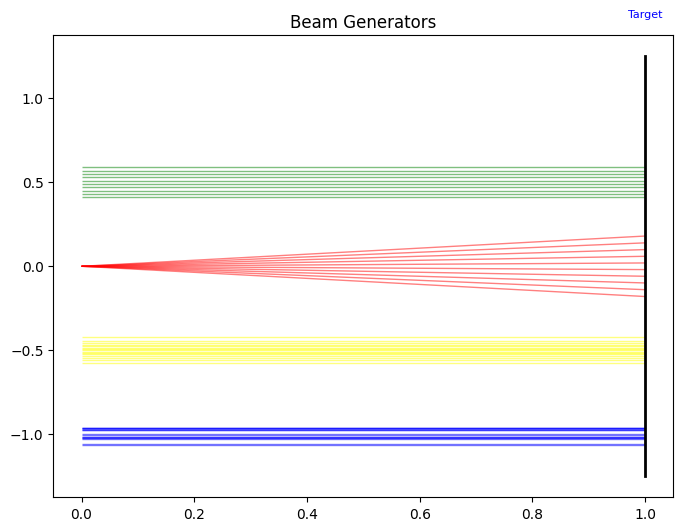

In [3]:
screen = co.Screen("Target", center=[1.0, 0.0], normal=[-1, 0], aperture=2.5)

# 1. Parallel (Green)
rays_para = co.generate_parallel_beam(
    wavelengths=[(550, 'green')],
    source_pos=[0.0, 0.5],
    target_element_centre=[1.0, 0.5],
    target_element_aperture=0.2,
    num_rays=10
)

# 2. Point Source (Red)
rays_point = co.generate_point_source(
    wavelengths=[(650, 'red')],
    source_pos=[0.0, 0.0],
    target_element_centre=[1.0, 0.0],
    target_element_aperture=0.4,
    num_rays=10
)

# 3. Gaussian_deter (Yellow)
rays_gauss_deter = co.generate_gaussian_beam_deter(
    wavelengths=[(600, 'yellow')],
    source_pos=[0.0, -0.5],
    target_element_centre=[1.0, -0.5],
    waist_radius=0.1,
    num_rays=15
)

# 4. Gausssian_mc (Blue)
rays_gauss_mc = co.generate_gaussian_beam_mc(
    wavelengths=[(450, 'blue')],
    source_pos=[0.0, -1.0],
    target_element_centre=[1.0, -1.0],
    waist_radius=0.1,
    num_rays=15
)

all_rays = rays_para + rays_point + rays_gauss_deter + rays_gauss_mc
co.run_simulation(all_rays, [screen], bounces=1, use_gpu=False)

fig, ax = plt.subplots(figsize=(8, 6))
co.plot_system(all_rays, [screen], ax)
plt.title("Beam Generators")
plt.show()

## 3. Screens & Apertures

### `Screen`
A detector plane. Rays that hit it are stopped and recorded.
* **`name`**: String ID.
* **`center`**: `[x, y]`.
* **`normal`**: `[nx, ny]` (Direction it faces).
* **`aperture`**: Width.

### `CircularAperture`
A stop/hole. Rays inside the radius pass; rays outside are blocked.
* **`name`**: String ID.
* **`center`**: `[x, y]`.
* **`normal`**: `[nx, ny]` (Direction it faces).
* **`radius`**: Size of the hole.
* **`outer_radius`**: Size of the blocking plate (default: 3x hole).

**Special Note:** Screens are the only element that 'captures' rays for `screen_result` analysis.

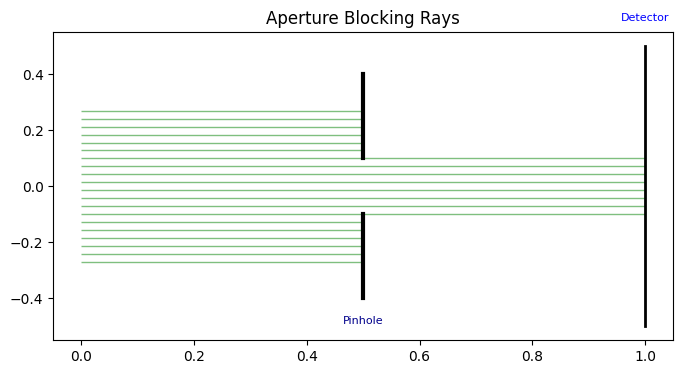

In [4]:
stop = co.CircularAperture(
    name="Pinhole", 
    center=[0.5, 0.0], 
    normal=[1, 0], 
    radius=0.1, 
    outer_radius=0.4
)

screen = co.Screen(
    name="Detector", 
    center=[1.0, 0.0], 
    normal=[-1, 0], 
    aperture=1.0
)

rays = co.generate_parallel_beam([(550, 'green')], [0.0, 0.0], [0.5, 0.0], 0.6, 20)
co.run_simulation(rays, [stop, screen], bounces=2, use_gpu=False)

fig, ax = plt.subplots(figsize=(8, 4))
co.plot_system(rays, [stop, screen], ax)
plt.title("Aperture Blocking Rays")
plt.show()

## 4. Thin Lenses & Gratings
Idealized elements that are geometrically flat but alter ray angles.

### `ThinLens`
Focuses light without thickness/aberration calculations. 
* **`name`**: String ID.
* **`center`**: `[x, y]`.
* **`normal`**: `[nx, ny]` (Direction it faces).
* **`aperture`**: Width.
* **`focal_length`**: Positive for convex, negative for concave.

**Special Note:** Small angle and paraxial approximation is used for calculation. This can lead to disstroted results for comparitively smaller focal lengths.

### `TransmissionGrating` & `ReflectiveGrating`
Diffracts light based on wavelength.
* **`name`**: String ID.
* **`center`**: `[x, y]`.
* **`normal`**: `[nx, ny]` (Direction it faces).
* **`aperture`**: Width.
* **`lines_per_mm`**: Groove density (e.g., 600).
* **`order`**: Diffraction order (usually 1 or -1).

**Special Note:** `TransmissionGrating` passes light through. `ReflectiveGrating` bounces it back.

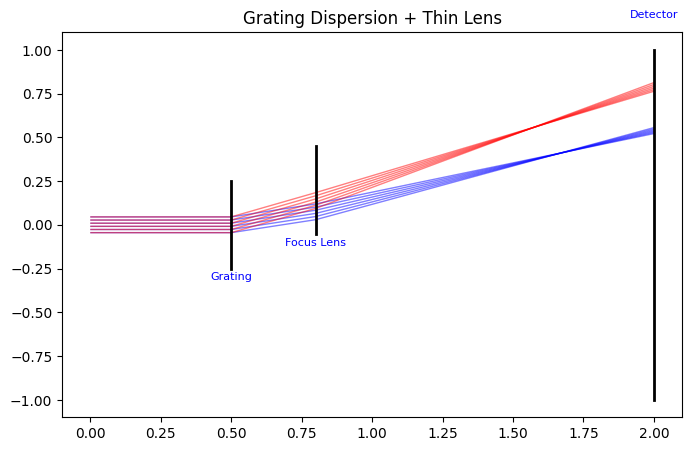

In [5]:
grating = co.TransmissionGrating(
    name="Grating", center=[0.5, 0.0], normal=[1, 0], aperture=0.5, 
    lines_per_mm=600, order=1
)
  
lens = co.ThinLens(
    name="Focus Lens", center=[0.8, 0.2], normal=[1, 0], aperture=0.5, 
    focal_length=1
)

screen = co.Screen(
    name="Detector", 
    center=[2.0, 0.0], 
    normal=[-1, 0], 
    aperture=2.0
)

rays = co.generate_parallel_beam([(400, 'blue'), (700, 'red')], [0.0, 0.0], [0.5, 0.0], 0.1, 6)
co.run_simulation(rays, [grating, lens, screen], bounces=5, use_gpu=False)

fig, ax = plt.subplots(figsize=(8, 5))
co.plot_system(rays, [grating, lens, screen], ax)
plt.title("Grating Dispersion + Thin Lens")
plt.show()

## 5. Mirrors

### `FlatMirror`
Standard planar reflection.
* **`name`**: String ID.
* **`center`**: `[x, y]`.
* **`normal`**: `[nx, ny]` (Direction it faces).
* **`aperture`**: Aperture of the mirror.

### `SphericalMirror`
Curved surface defined by a radius.
* **`name`**: String ID.
* **`center`**: `[x, y]`.
* **`normal`**: `[nx, ny]` (Direction it faces).
* **`aperture`**: Aperture of the mirror.
* **`radius`**: Distance to center of curvature.
* **Special Note:** Suffers from Spherical Aberration (rays don't meet perfectly).

### `ParabolicMirror`
Ideal focusing shape.
* **`name`**: String ID.
* **`center`**: `[x, y]`.
* **`normal`**: `[nx, ny]` (Direction it faces).
* **`aperture`**: Aperture of the mirror.
* **`focal_length`**: Distance to focus.
* **Special Note:** Focuses parallel light to a perfect point.

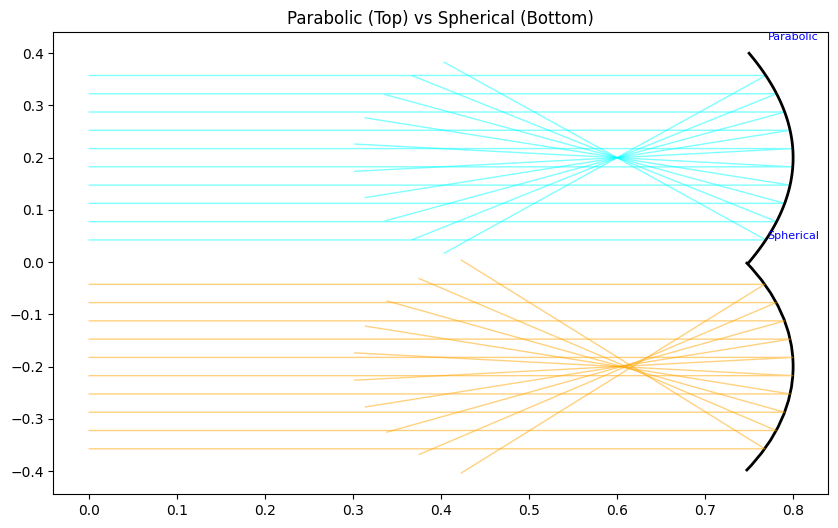

In [ ]:
para = co.ParabolicMirror(
    name="Parabolic", 
    center=[0.8, 0.2], 
    normal=[-1, 0], 
    aperture=0.4, 
    focal_length=0.2
)

sphere = co.SphericalMirror(
    name="Spherical", 
    center=[0.8, -0.2], 
    normal=[-1, 0], 
    aperture=0.4, 
    radius=0.4
)

rays_1 = co.generate_parallel_beam([(550, 'cyan')], [0, 0.2], [0.8, 0.2], 0.35, 10)
rays_2 = co.generate_parallel_beam([(600, 'orange')], [0, -0.2], [0.8, -0.2], 0.35, 10)

co.run_simulation(rays_1 + rays_2, [para, sphere], bounces=2, use_gpu=False)

fig, ax = plt.subplots(figsize=(10, 6))
co.plot_system(rays_1 + rays_2, [para, sphere], ax)
plt.title("Parabolic (Top) vs Spherical (Bottom)")
plt.show()

## 6. Refractive Elements
These elements use Snell's Law and the internal glass database. Note that the engine is configured for the case where no two refractive elements overlap. 
**Refractive Index Options:**
1. Either choose the string `'BK7'`, `'F2'`, `'SF10'` or `'SiO2'` to use the inbuilt library.
2. Input a fixed float/int value.
3. Input a Sellmeier equation compatible dictionary (eg. {'B1': 1.03961212, 'B2': 0.231792344, 'B3': 1.01046945, 'C1': 0.00600069867, 'C2': 0.0200179144, 'C3': 103.560653}).
4. Input the numerical values directly as a list in the specific order as above.

### `Slab`
Rectangular block of glass.
* **`name`**: String ID.
* **`center`**: `[x, y]`.
* **`normal`**: `[nx, ny]` (Direction it faces).
* **`aperture`**: Aperture of the element.
* **`refractive_index`**: Look above.
* **`thickness`**: Depth of the block.
* **Special Note:** The pair of sides facing in a direction perperndicular to the defined normal dont act as refractive surfaces and allow the rays to pass without bending. Combine 2 slabs (in perpendicular directions) to make all 4 sides functional.

### `Lens` (Thick)
Real lens with two curved surfaces.
* **`name`**: String ID.
* **`center`**: `[x, y]`.
* **`normal`**: `[nx, ny]` (Direction it faces).
* **`aperture`**: Constraint aperture of the element. If the thickness and the radii of curvature result in the geometric aperture, min(constraint aperture, geometric aperture). 
* **`refractive_index`**: Look above.
* **`R1`**: Radius of front surface (+ means convex).
* **`R2`**: Radius of back surface (+ means concave).
* **`thickness`**: Thickness at the center.
* **Special Note:** Suffers from Spherical Aberration (rays don't meet perfectly). If the constraint aperture clamps the aperture, the clamped surfaces don't act as a surface and allow rays to pass through unchanged. Use a slab as in the above case to make the clamped surfaces functional.

### `Prism`
Isosceles prism for dispersion.
* **`name`**: String ID.
* **`center`**: `[x, y]`.
* **`normal`**: `[nx, ny]` (Direction the unequal side faces).
* **`aperture`**: Aperture of the element.
* **`refractive_index`**: Look above.
* **`apex_angle`**: Top angle.
* **`side_length`**: Size of the 2 equal faces.

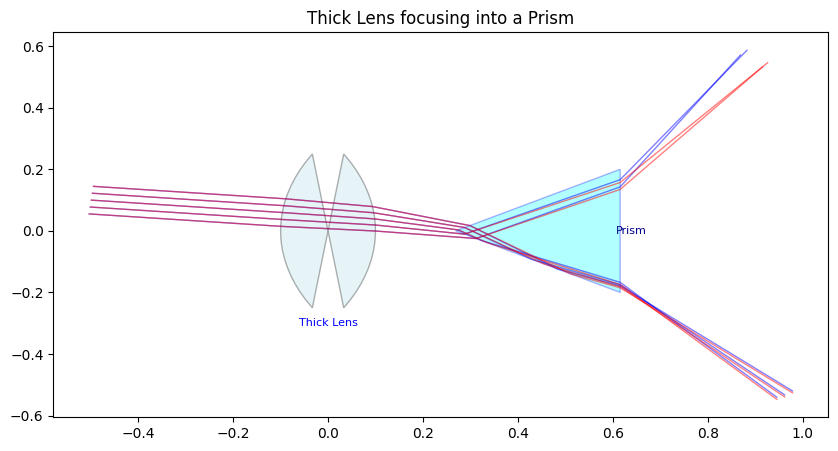

In [ ]:
prism = co.Prism(
    name="Prism", 
    center=[0.5, 0.0], 
    normal=[1, 0], 
    refractive_index='SF10', 
    apex_angle=60, 
    side_length=0.4
)

lens = co.Lens(
    name="Thick Lens", 
    center=[0.0, 0.0], 
    normal=[1, 0], 
    aperture=0.5, 
    refractive_index=1.5, 
    R1=0.5, 
    R2=-0.5, 
    thickness=0.2
)

rays = co.generate_parallel_beam([(400, 'blue'), (700, 'red')], np.array([-0.5, 0.1]), np.array([0.5, 0.0]), 0.1, 5)
co.run_simulation(rays, [lens, prism], bounces=10, use_gpu=False)

fig, ax = plt.subplots(figsize=(10, 5))
co.plot_system(rays, [lens, prism], ax)
plt.title("Thick Lens focusing into a Prism")
plt.show()

## 7. Analysis

### `co.screen_result(screen, rays)`
Returns statistics about rays hitting a specific screen.
* **Returns**: Dictionary containing:
    * `rms_radius`: Root Mean Square radius of the spot.
    * `mean_pos`: [x, y] centroid.
    * `count`: Number of rays detected.


--- Analysis for Screen: 'Sensor' ---
Rays Captured: 20 / 20
Centroid (Global): [ 0.00000000e+00 -5.55111512e-18]
RMS Spot Radius:   0.109256 units
Max Spot Radius:   0.180000 units
Variance (x, y):   [0.         0.01193684]


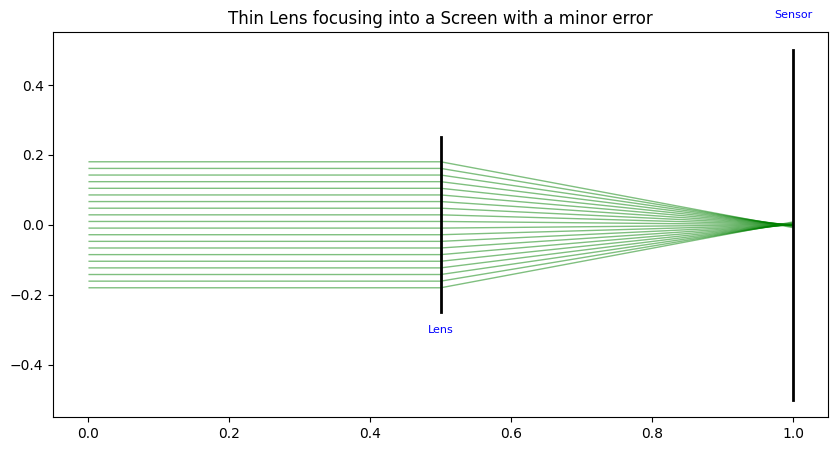

In [8]:
screen = co.Screen("Sensor", center=[1.0, 0.0], normal=[-1, 0], aperture=1.0)
lens = co.ThinLens("Lens", center=[0.5, 0.0], normal=[1, 0], aperture=0.5, focal_length=0.5)

# Imperfect focus test
rays = co.generate_parallel_beam([(550, 'green')], [0,0], [0.5,0], 0.4, 20)
co.run_simulation(rays, [lens, screen], bounces=5, use_gpu=False)

# Get Stats and plot
fig, ax = plt.subplots(figsize=(10, 5))
stats = co.screen_result(screen, rays)
co.plot_system(rays, [lens, screen], ax)
plt.title("Thin Lens focusing into a Screen with a minor error")
plt.show()

## 8. Advanced Examples

### Example A: Beam Expander (Keplerian)
Two positive lenses separated by the sum of their focal lengths ($f_1 + f_2$) expands the beam diameter.

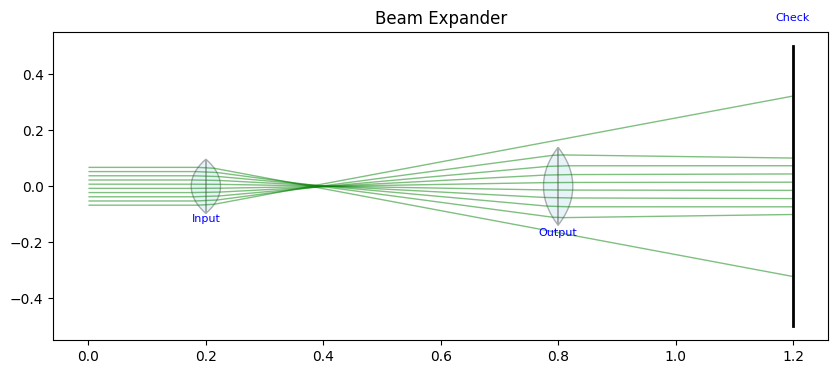

In [36]:
L1 = co.Lens("Input", [0.2, 0.0], [1, 0], 0.3, 1.5, 0.2, -0.2, 0.05) # Small Lens
L2 = co.Lens("Output", [0.8, 0.0], [1, 0], 0.6, 1.5, 0.4, -0.4, 0.05) # Large Lens
screen = co.Screen("Check", [1.2, 0.0], [-1, 0], 1.0)

rays = co.generate_parallel_beam([(550, 'green')], [0,0], [0.2,0], 0.15, 10)
co.run_simulation(rays, [L1, L2, screen], bounces=10, use_gpu=False)

fig, ax = plt.subplots(figsize=(10, 4))
co.plot_system(rays, [L1, L2, screen], ax)
plt.title("Beam Expander")
plt.show()

### Example B: Folded Spectrometer
Light enters -> Reflects off mirror -> Hits Grating -> Focuses on Detector.

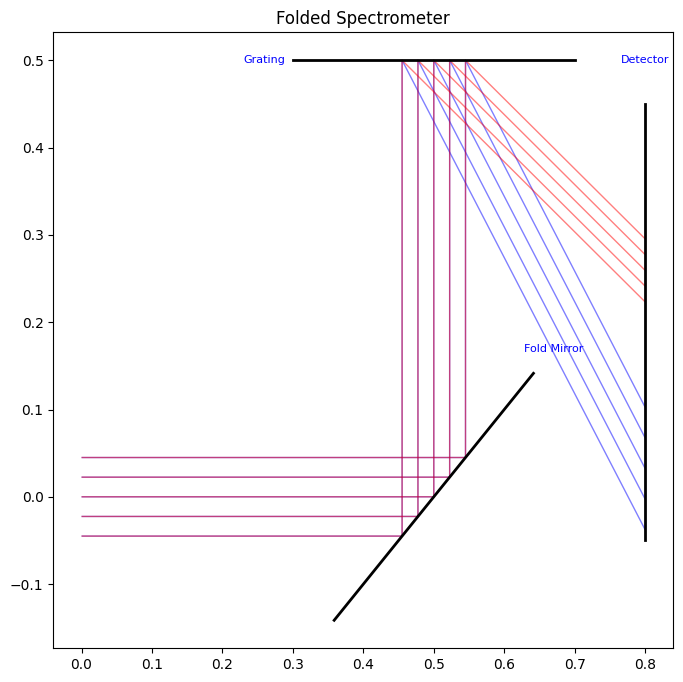

In [11]:
mirror = co.FlatMirror("Fold Mirror", [0.5, 0.0], [-1, 1], 0.4) # 45 deg angle
grating = co.ReflectiveGrating("Grating", [0.5, 0.5], [0, -1], 0.4, 600, 2)
screen = co.Screen("Detector", [0.8, 0.2], [-1, 0], 0.5)

rays = co.generate_parallel_beam([(450, 'blue'), (650, 'red')], [0.0, 0.0], [0.5, 0.0], 0.1, 5)
co.run_simulation(rays, [mirror, grating, screen], bounces=5, use_gpu=False)

fig, ax = plt.subplots(figsize=(8, 8))
co.plot_system(rays, [mirror, grating, screen], ax)
plt.title("Folded Spectrometer")
plt.show()

### Example C: Mirror inside a Glass Slab

We can put a mirror inside a slab in the following way:

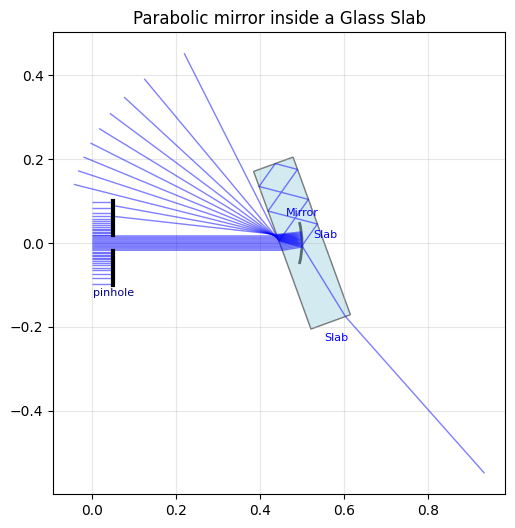

In [51]:
# Elements
ang = np.radians(20)
g_norm = [np.cos(ang), np.sin(ang)]
glass_1 = co.Slab("Slab", [0.5, 0], g_norm, 0.4, "BK7", 0.1)

g_tan = [-np.sin(ang), np.cos(ang)]
glass_2 = co.Slab("Slab", [0.5, 0], g_tan, 0.1, "BK7", 0.4)

p_mirror = co.SphericalMirror("Mirror", [0.5, 0], [-1, 0], 0.1, 0.2)

aperture = co.CircularAperture("pinhole", [0.05, 0], [1, 0], 0.02, 0.1)

# Define the list of elements
elements = [aperture, p_mirror, glass_1, glass_2]
    
waves = [(100, 'blue')]
rays = co.generate_gaussian_beam_deter(waves, [0,0], [1, 0], 0.1, 40)

# Simulate
co.run_simulation(rays, elements, 15, False)

#Plot
fig, ax = plt.subplots(figsize=(10, 6))
co.plot_system(rays, elements, ax)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_title("Parabolic mirror inside a Glass Slab")
plt.show()